In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from pickle import dump
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import matplotlib.pyplot as plt

In [3]:
data_sent = pd.read_csv('data/data_sentiment.csv')

### Analysis of dataset

In [ ]:
sum([True if 'tsla' in i.lower() or '@tesla' in i.lower() or '$tesla' in i.lower() else False for i in data_sent['Tweet']])


In [ ]:
tsla = data_sent[data_sent["Stock Name"] == 'TSLA']['Tweet']
print(len(tsla))
iter = [True if 'tsla' in i.lower() or '@tesla' in i.lower() or '$tesla' in i.lower() else False for i in data_sent['Tweet']]
for n,i in enumerate(iter):
    if not i:
        print(tsla[n])

In [ ]:
for tweet, stock in zip(data_sent['Tweet'],data_sent['Stock Name']):
    if 'tesla' in tweet.lower() and stock != 'TSLA':
        print(tweet)

###### Conclusion : stocks are being picked based on name of the company or stock ticker
###### If a twitter post discusses more than one stock then column "Stock name" is empty

### Actual prediction

In [4]:
prices_hist = pd.read_csv('data/stock_yfinance_data.csv')

In [51]:
data_sent

,Stock Name,positive,neutral,negative,Day
0,TSLA,0.0573,0.2339,0.7088,2022-09-29
1,TSLA,0.3148,0.6753,0.0099,2022-09-29
2,TSLA,0.0785,0.8904,0.0311,2022-09-29
3,TSLA,0.0120,0.0724,0.9156,2022-09-29
4,TSLA,0.0052,0.0452,0.9497,2022-09-29
...,...,...,...,...,...
80788,XPEV,0.9481,0.0486,0.0033,2021-10-07
80789,XPEV,0.4226,0.5692,0.0082,2021-10-04
80790,XPEV,0.9137,0.0832,0.0031,2021-10-01
80791,XPEV,0.9433,0.0543,0.0024,2021-10-01


In [5]:
prices_hist

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...
6295,2022-09-23,13.090000,13.892000,12.860000,13.710000,13.710000,28279600,XPEV
6296,2022-09-26,14.280000,14.830000,14.070000,14.370000,14.370000,27891300,XPEV
6297,2022-09-27,14.580000,14.800000,13.580000,13.710000,13.710000,21160800,XPEV
6298,2022-09-28,13.050000,13.421000,12.690000,13.330000,13.330000,31799400,XPEV


In [6]:
prices_hist['Stock Name'].unique()

array(['TSLA', 'MSFT', 'PG', 'META', 'AMZN', 'GOOG', 'AMD', 'AAPL',
       'NFLX', 'TSM', 'KO', 'F', 'COST', 'DIS', 'VZ', 'CRM', 'INTC', 'BA',
       'BX', 'NOC', 'PYPL', 'ENPH', 'NIO', 'ZS', 'XPEV'], dtype=object)

In [7]:
data_sent['Date'] = pd.to_datetime(data_sent['Date'])  # Convert 'Date' column to datetime

data_sent['Day'] = data_sent['Date'].dt.date 

In [8]:
data_sent.drop(columns=['Date','Tweet', 'Company Name'], inplace=True)

In [52]:
def df_for_inp(data, prices, ticker : str):

    data = data[data['Stock Name'] == ticker]
    data = data.drop(columns=['Stock Name'], inplace = False)
    twitter_df = data.groupby('Day').mean()
    twitter_df['Date'] = twitter_df.index
    twitter_df = twitter_df.reset_index(drop=True)

    prices['Date'] = pd.to_datetime(prices['Date'])
    prices = prices[prices['Stock Name'] == ticker]

    twitter_df['Date'] = pd.to_datetime(twitter_df['Date'])

    df = pd.merge(twitter_df, prices, on='Date', how='inner')

    df = df[df['Stock Name'] == ticker]

    df = df.sort_values(by='Date')
    df = df.drop(columns='Date')
    df = df.drop(columns='Stock Name')

    return df

In [10]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [11]:
def normalize_data(df, range, target_column):

    '''
    df: dataframe object
    range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
    target_column: type str -> should reflect closing price of stock
    '''

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)
    
    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset,y_scaler)

In [54]:
def train(data, prices, ticker : str):

    tsl_train, tsl_test = split_train_test(df_for_inp(data, prices, ticker))

    tsl_train_x, tsl_train_y, y_scaler_train =  normalize_data(tsl_train, (-1,1), "Close")
    tsl_test_x, tsl_test_y, y_scaler_test =  normalize_data(tsl_test, (-1,1), "Close")

    # Define LSTM model
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(tsl_train_x.shape[1], 1)),
        LSTM(units=50, return_sequences=False),
        Dense(units=25),
        Dense(units=1)
    ])

        # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(tsl_train_x, tsl_train_y, epochs=100, batch_size=32)

    predictions = model.predict(tsl_test_x)

    # Inverse scale the predictions
    predictions = y_scaler_test.inverse_transform(predictions)

    test_y = y_scaler_test.inverse_transform(tsl_test_y)

    return predictions, test_y

In [60]:
def rmse_out(predictions, test_y):
    # determine rmse

    # For regression problems
    mse = mean_squared_error(predictions, test_y)
    mae = mean_absolute_error(predictions, test_y)
    rmse = np.sqrt(mse)
    return rmse

In [58]:
def plot(predictions, test_y, ticker):
    
    # Plotting the two series
    plt.plot(predictions, label='Predicted')
    plt.plot(test_y, label='Test')

    # Adding labels and title
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title(f'Prediction of {ticker}')

    # Adding legend
    plt.legend()

    # Displaying the plot
    plt.show()

c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.4691
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2421
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0496
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0272
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0085
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018
Epoch 16/100
7/7 ━━━

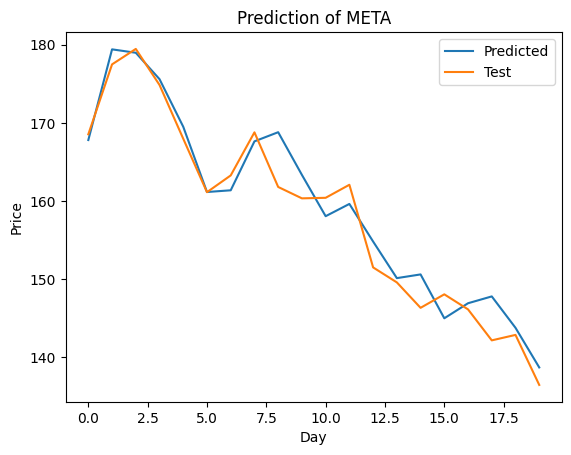

In [61]:
ticker = 'META'
predictions, test_y = train(data_sent, prices_hist, ticker)
print(f'rmse: {rmse_out(predictions, test_y)}')
plot(predictions, test_y, ticker)

Epoch 1/100


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1612
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0565 
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0170 
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0123 
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0089
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081 
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0075 
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071 
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 
Epoch 16/100
8/8 ━━━━━━━━━━━━━━━

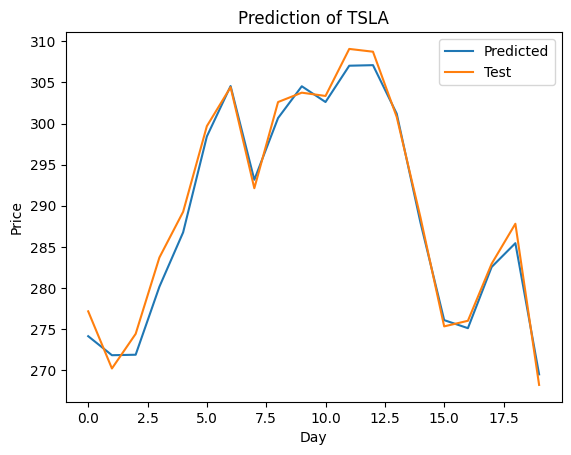

In [62]:
ticker = 'TSLA'
predictions, test_y = train(data_sent, prices_hist, ticker)
print(f'rmse: {rmse_out(predictions, test_y)}')
plot(predictions, test_y, ticker)

Epoch 1/100


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2388
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0992
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0160
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0196 
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085 
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0095 
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061 
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 
Epoch 16/100
8/8 ━━━━━━━━━━━━━━━━━

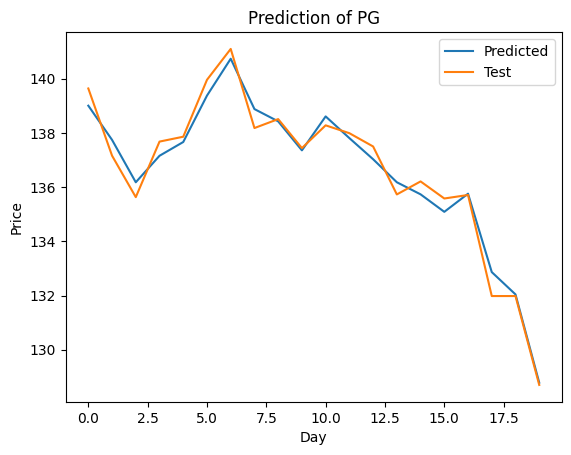

In [63]:
ticker = 'PG'
predictions, test_y = train(data_sent, prices_hist, ticker)
print(f'rmse: {rmse_out(predictions, test_y)}')
plot(predictions, test_y, ticker)

Epoch 1/100


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2263
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0504 
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0225 
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0104 
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 
Epoch 16/100
8/8 ━━━━━━━━━━━━━━━

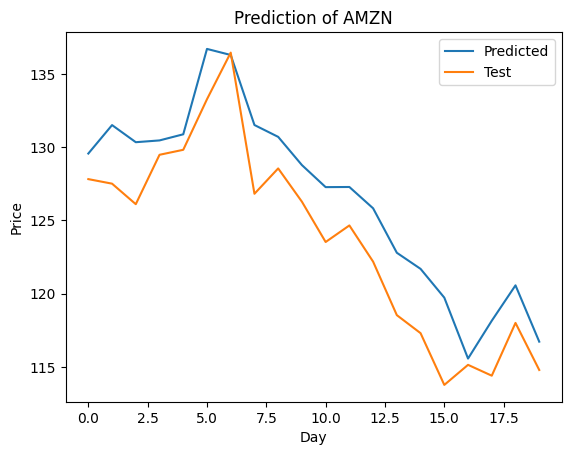

In [64]:
ticker = 'AMZN'
predictions, test_y = train(data_sent, prices_hist, ticker)
print(f'rmse: {rmse_out(predictions, test_y)}')
plot(predictions, test_y, ticker)

Epoch 1/100


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.3100
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1611 
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0219 
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0278 
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0099 
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 
Epoch 16/100
7/7 ━━━━━━━━━━━━━━

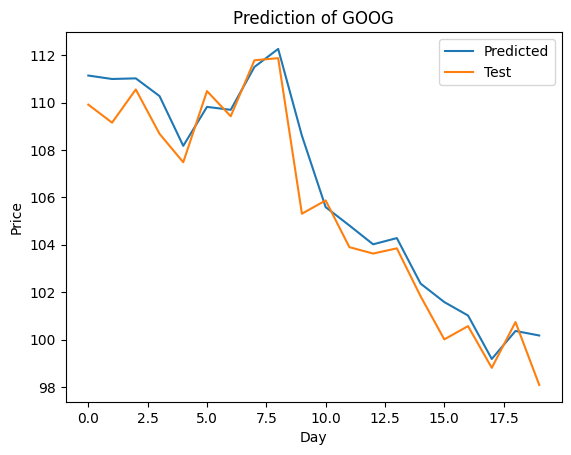

In [65]:
ticker = 'GOOG'
predictions, test_y = train(data_sent, prices_hist, ticker)
print(f'rmse: {rmse_out(predictions, test_y)}')
plot(predictions, test_y, ticker)

Epoch 1/100


c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2418
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1032 
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0408 
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0112 
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048
Epoch 16/100
8/8 ━━━━━━━━━━━━━━━━━

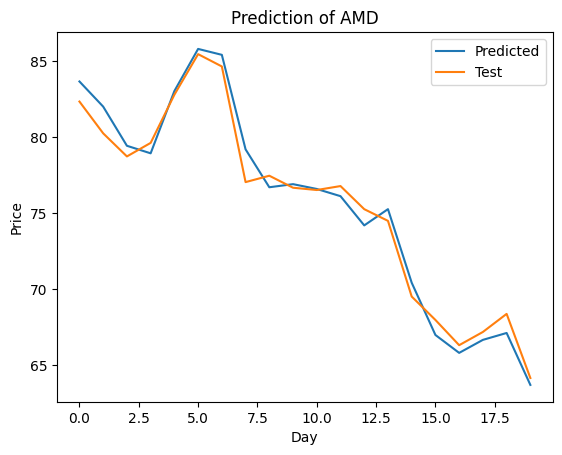

In [66]:
ticker = 'AMD'
predictions, test_y = train(data_sent, prices_hist, ticker)
print(f'rmse: {rmse_out(predictions, test_y)}')
plot(predictions, test_y, ticker)

c:\Users\ondre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.2184
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0686
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0113
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0113
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0082
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 
Epoch 16/100
8/8 ━━━━━━━━━━━━

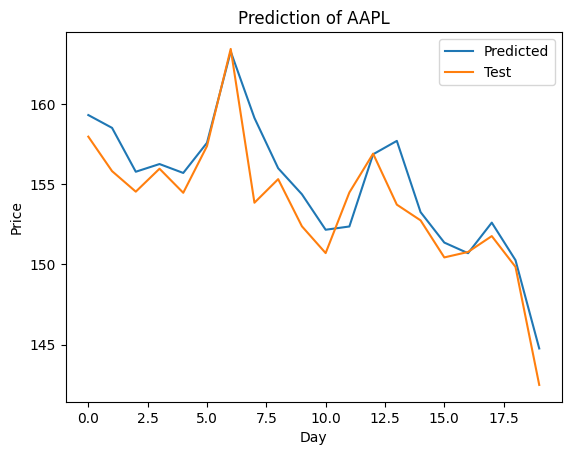

In [68]:
ticker = 'AAPL'
predictions, test_y = train(data_sent, prices_hist, ticker)
print(f'rmse: {rmse_out(predictions, test_y)}')
plot(predictions, test_y, ticker)